In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, precision_score, recall_score, accuracy_score, roc_auc_score, roc_curve, precision_recall_curve, f1_score, fbeta_score
from sklearn.metrics import log_loss
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier


# preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics

In [2]:
sepsis_df = pd.read_csv('sepsis_df.csv')

# create X and y for model
X = sepsis_df.drop(columns=['isSepsis'])
y = sepsis_df.isSepsis

In [3]:
# splitting into train, val, test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=248)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=248)

In [4]:
# very imbalanced dataset, needs resampling!
from collections import Counter
Counter(y_train)

Counter({0: 10344, 1: 292})

In [5]:
# resampling using random oversampling
from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler(random_state=0)

X_train, y_train = ros.fit_resample(X_train,y_train)

In [6]:
Counter(y_train)

Counter({0: 10344, 1: 10344})

In [7]:
# import standard scaler
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.fit_transform(X_val)
X_test_scaled = scaler.fit_transform(X_test)

In [8]:
from sklearn.metrics import make_scorer
# creating a new scoring metric that uses beta = 2
f_beta_2 = make_scorer(fbeta_score, beta=2)

In [88]:
def scores(y_true, y_pred, model):
    
    model_score_df = pd.DataFrame()
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    fbeta = fbeta_score(y_true, y_pred, beta=2) 
    
    temp_df = pd.DataFrame([[str(model), accuracy, precision, recall, f1, fbeta]])
        
    model_score_df = pd.concat([model_score_df, temp_df])
    model_score_df.columns = ['model', 'accuracy', 'precision', 'recall', 'f1', 'fbeta']
    
    return model_score_df

#     print(f'Accuracy score: {accuracy}')
#     print(f'Precision score: {precision}')
#     print(f'Recall: {recall}')
#     print(f'F1: {f1}')
#     print(f'F-beta (beta=2): {fbeta}')

In [10]:
def make_confusion_matrix(model, threshold=0.5):
    # Predict class 1 if probability of being in class 1 is greater than threshold
    # (model.predict(X_test) does this automatically with a threshold of 0.5)
    y_predict = (model.predict_proba(X_val_scaled)[:, 1] >= threshold)
    sepsis_confusion = confusion_matrix(y_val, y_predict)
    plt.figure(dpi=80)
    sns.heatmap(sepsis_confusion, cmap=plt.cm.Blues, annot=True, square=True, fmt='d',
           xticklabels=['No Sepsis', 'Sepsis'],
           yticklabels=['No Sepsis', 'Sepsis']);
    plt.xlabel('prediction')
    plt.ylabel('actual')

# KNN

In [11]:
knn = KNeighborsClassifier(n_neighbors = 5, weights='distance')
knn.fit(X_train_scaled, y_train)

knn_train_pred = knn.predict(X_train_scaled)
knn_val_pred = knn.predict(X_val_scaled)

KNN Test Set Scores

In [12]:
scores(y_train, knn_train_pred)

Accuracy score: 1.0
Precision score: 1.0
Recall: 1.0
F1: 1.0
F-beta (beta=2): 1.0


KNN Val Set Scores

In [57]:
scores(y_val, knn_val_pred, 'knn')

,model,accuracy,precision,recall,f1,fbeta
0,knn,0.874812,0.088685,0.453125,0.148338,0.248714


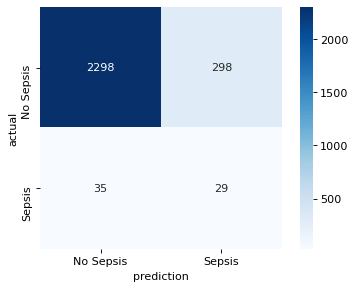

In [14]:
make_confusion_matrix(knn)

## Logistic Regression

In [15]:
logit = LogisticRegression()
logit.fit(X_train_scaled, y_train)

logit_train_pred = logit.predict(X_train_scaled)
logit_val_pred = logit.predict(X_val_scaled)

Logistic Regression Train Set Scores:

In [16]:
scores(y_train, logit_train_pred)

Accuracy score: 0.7589907192575406
Precision score: 0.7974683544303798
Recall: 0.6943155452436195
F1: 0.7423255813953489
F-beta (beta=2): 0.7127545551982851


Logistic Regression Val Set Scores:

In [17]:
scores(y_val, logit_val_pred)

Accuracy score: 0.5176691729323308
Precision score: 0.04
Recall: 0.828125
F1: 0.07631389488840892
F-beta (beta=2): 0.16761543327008224


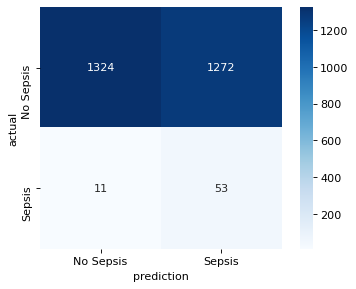

In [18]:
make_confusion_matrix(logit)

## Random Forest

In [19]:
rf = RandomForestClassifier()
rf.fit(X_train, y_train)

rf_train_pred = rf.predict(X_train)
rf_val_pred = rf.predict(X_val)

Random Forest Train Set Scores

In [20]:
scores(y_train, rf_train_pred)

Accuracy score: 1.0
Precision score: 1.0
Recall: 1.0
F1: 1.0
F-beta (beta=2): 1.0


Random Forest Val Set Scores

In [21]:
scores(y_val, rf_val_pred)

Accuracy score: 0.9796992481203007
Precision score: 0.7083333333333334
Recall: 0.265625
F1: 0.3863636363636364
F-beta (beta=2): 0.30357142857142855


In [22]:
def make_confusion_matrix_unscaled(model, threshold=0.5):
    # Predict class 1 if probability of being in class 1 is greater than threshold
    # (model.predict(X_test) does this automatically with a threshold of 0.5)
    y_predict = (model.predict_proba(X_val)[:, 1] >= threshold)
    sepsis_confusion = confusion_matrix(y_val, y_predict)
    plt.figure(dpi=80)
    sns.heatmap(sepsis_confusion, cmap=plt.cm.Blues, annot=True, square=True, fmt='d',
           xticklabels=['No Sepsis', 'Sepsis'],
           yticklabels=['No Sepsis', 'Sepsis']);
    plt.xlabel('prediction')
    plt.ylabel('actual')

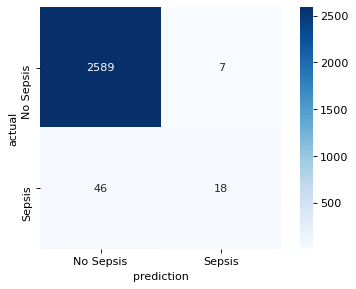

In [23]:
make_confusion_matrix_unscaled(rf)

In [24]:
knn_fpr, knn_tpr, knn_thresh = roc_curve(y_val, knn.predict_proba(X_val_scaled)[:,1])
logit_fpr, logit_tpr, logit_thresh = roc_curve(y_val, logit.predict_proba(X_val_scaled)[:,1])
rf_fpr, rf_tpr, rf_thresh = roc_curve(y_val, rf.predict_proba(X_val)[:,1])


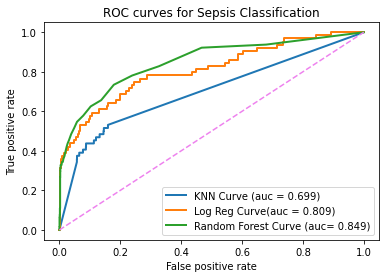

In [32]:
# fpr, tpr, thresholds = roc_curve(y_val, rf.predict_proba(X_val)[:,1])

roc_auc_knn = (roc_auc_score(y_val, knn.predict_proba(X_val_scaled)[:,1]))
roc_auc_logit = (roc_auc_score(y_val, logit.predict_proba(X_val_scaled)[:,1]))
roc_auc_rf = (roc_auc_score(y_val, rf.predict_proba(X_val)[:,1]))                    
plt.plot(knn_fpr, knn_tpr, lw=2, label = f'KNN Curve (auc = {roc_auc_knn.round(3)})')
plt.plot(logit_fpr, logit_tpr, lw=2, label = f'Log Reg Curve(auc = {roc_auc_logit.round(3)})')
plt.plot(rf_fpr, rf_tpr, lw=2, label = f'Random Forest Curve (auc= {roc_auc_rf.round(3)})')





plt.plot([0,1],[0,1],c='violet',ls='--')
plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1.05])


plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curves for Sepsis Classification');
# print("ROC AUC score = ", roc_auc_score(y_val, rf.predict_proba(X_val)[:,1]))
plt.legend(loc='lower right')

In [26]:
fbeta_knn = fbeta_score(y_val, knn_val_pred, beta=2)
fbeta_logit = fbeta_score(y_val, logit_val_pred, beta=2)
fbeta_rf = fbeta_score(y_val, rf_val_pred, beta=2)

In [27]:
f_beta_scores = {'model':['knn','logistic regression','random forest'],
                 'score':[fbeta_score(y_val, knn_val_pred, beta=2),
                          fbeta_score(y_val, logit_val_pred, beta=2),
                         fbeta_score(y_val, rf_val_pred, beta=2)]}

In [28]:
f_beta_scores

{'model': ['knn', 'logistic regression', 'random forest'],
 'score': [0.24871355060034306, 0.16761543327008224, 0.30357142857142855]}

In [29]:
fbeta_df = pd.DataFrame.from_dict(f_beta_scores)

In [30]:
fbeta_df

,model,score
0,knn,0.248714
1,logistic regression,0.167615
2,random forest,0.303571


Text(0.5, 1.0, 'Baseline F-beta (b=2) Scores')

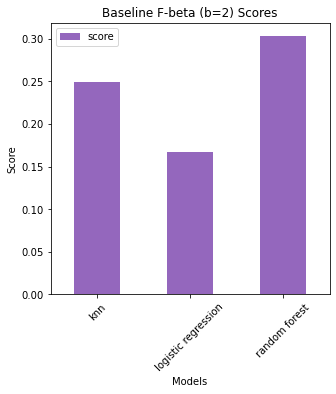

In [87]:
fbeta_df.plot(x = 'model', kind='bar', color='tab:purple', figsize=(5,5))
plt.xticks(rotation=45)
plt.xlabel('Models')
plt.ylabel('Score')
plt.title('Baseline F-beta (b=2) Scores')

In [33]:
feature_importance_df = pd.DataFrame({'feat_importance':rf.feature_importances_}, index=X_val.columns).sort_values(by='feat_importance', ascending=False)

In [68]:
knn_scores = scores(y_val, knn_val_pred, 'knn')

In [69]:
logit_scores = scores(y_val, logit_val_pred, 'logistic regression')

In [70]:
rf_scores = scores(y_val, rf_val_pred, 'random forest')

In [72]:
all_scores_df = knn_scores.append(logit_scores).append(rf_scores)

In [50]:
def score_visualizer(df):
    ax = df.plot(x='model', kind='bar', figsize=(9,5))
    
    plt.xticks(rotation=45)
    plt.xlabel('Models')
    plt.ylabel('Score')
    plt.title('Baseline Scores for All Models')

In [90]:
all_scores_df

,model,accuracy,precision,recall,f1,fbeta
0,knn,0.874812,0.088685,0.453125,0.148338,0.248714
0,logistic regression,0.517669,0.040000,0.828125,0.076314,0.167615
0,random forest,0.979699,0.708333,0.265625,0.386364,0.303571


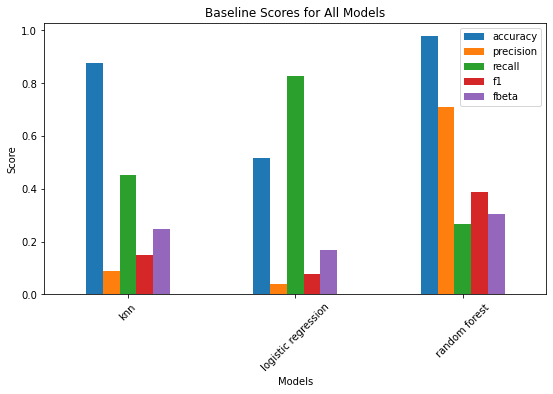

In [73]:
score_visualizer(all_scores_df)